Autorzy:
107851
107683
105647

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [7]:
import os

base_dir = os.path.abspath('')
path = os.path.join(base_dir, '../Przetwarzanie Danych/')
co2_production = pd.read_csv(path + 'co2_production.csv')
gni_per_capita = pd.read_csv(path + 'gross_national_income_per_capital.csv')
hdi = pd.read_csv(path + 'human_development_index.csv')
life_expectancy = pd.read_csv(path + 'life_expectancy_by_birth.csv')

all_data = life_expectancy.copy()

In [8]:
for dataframe in [co2_production, gni_per_capita, hdi]:
    all_data = all_data.merge(dataframe, on='Country', how='outer', suffixes=('', '_drop'))

all_data = all_data[all_data.columns.drop(list(all_data.filter(regex='_drop')))]

columns_to_drop = ['ISO3', 'hdicode', 'hdi_rank_2021']
all_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


all_data['avg_co2'] = all_data.filter(like='co2_prod_').mean(axis=1)
all_data['avg_gni'] = all_data.filter(like='gnipc_').mean(axis=1)  

In [9]:
for year in range(1990, 2022):
    co2_column_name = f"co2_prod_{year}"
    gni_column_name = f"gnipc_{year}"
    estimated_population_column_name = f"estimated_population_{year}"
    co2_per_capita_column_name = f"co2_per_capita_{year}"
    
    if co2_column_name in all_data.columns and gni_column_name in all_data.columns:
        all_data[estimated_population_column_name] = all_data[co2_column_name] / all_data[gni_column_name]
        all_data[co2_per_capita_column_name] = all_data[co2_column_name] / all_data[estimated_population_column_name]


print(all_data['avg_co2'].describe())
print(all_data['avg_gni'].describe())

count    204.000000
mean       4.499696
std        5.972266
min        0.038186
25%        0.639804
50%        2.227585
75%        6.370562
max       48.440912
Name: avg_co2, dtype: float64
count       204.000000
mean      16488.239856
std       18703.085972
min         841.037957
25%        3768.881573
50%        9515.751330
75%       20114.611191
max      111709.939782
Name: avg_gni, dtype: float64


In [10]:
all_data['co2_gni_interaction'] = all_data['avg_co2'] * all_data['avg_gni']

In [11]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col].fillna(all_data[col].mode()[0], inplace=True)
    else:
        all_data[col].fillna(all_data[col].mean(), inplace=True)

encoder = OneHotEncoder(drop='first')
encoded_region = encoder.fit_transform(all_data[['region']])
encoded_region_df = pd.DataFrame(encoded_region.toarray(), columns=encoder.get_feature_names_out(['region']))
all_data = pd.concat([all_data.drop(['region'], axis=1), encoded_region_df], axis=1)

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
all_data

,Country,le_1990,le_1991,le_1992,le_1993,le_1994,le_1995,le_1996,le_1997,le_1998,le_1999,le_2000,le_2001,le_2002,le_2003,le_2004,le_2005,le_2006,le_2007,le_2008,le_2009,le_2010,le_2011,le_2012,le_2013,le_2014,le_2015,le_2016,le_2017,le_2018,le_2019,le_2020,le_2021,co2_prod_1990,co2_prod_1991,co2_prod_1992,co2_prod_1993,co2_prod_1994,co2_prod_1995,co2_prod_1996,co2_prod_1997,co2_prod_1998,co2_prod_1999,co2_prod_2000,co2_prod_2001,co2_prod_2002,co2_prod_2003,co2_prod_2004,co2_prod_2005,co2_prod_2006,co2_prod_2007,co2_prod_2008,co2_prod_2009,co2_prod_2010,co2_prod_2011,co2_prod_2012,co2_prod_2013,co2_prod_2014,co2_prod_2015,co2_prod_2016,co2_prod_2017,co2_prod_2018,co2_prod_2019,co2_prod_2020,co2_prod_2021,gnipc_1990,gnipc_1991,gnipc_1992,gnipc_1993,gnipc_1994,gnipc_1995,gnipc_1996,gnipc_1997,gnipc_1998,gnipc_1999,gnipc_2000,gnipc_2001,gnipc_2002,gnipc_2003,gnipc_2004,gnipc_2005,gnipc_2006,gnipc_2007,gnipc_2008,gnipc_2009,gnipc_2010,gnipc_2011,gnipc_2012,gnipc_2013,gnipc_2014,gnipc_2015,gnipc_2016,gnipc_2017,gnipc_2018,gnipc_2019,gnipc_2020,gnipc_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,hdi_1997,hdi_1998,hdi_1999,hdi_2000,hdi_2001,hdi_2002,hdi_2003,hdi_2004,hdi_2005,hdi_2006,hdi_2007,hdi_2008,hdi_2009,hdi_2010,hdi_2011,hdi_2012,hdi_2013,hdi_2014,hdi_2015,hdi_2016,hdi_2017,hdi_2018,hdi_2019,hdi_2020,hdi_2021,avg_co2,avg_gni,estimated_population_1990,co2_per_capita_1990,estimated_population_1991,co2_per_capita_1991,estimated_population_1992,co2_per_capita_1992,estimated_population_1993,co2_per_capita_1993,estimated_population_1994,co2_per_capita_1994,estimated_population_1995,co2_per_capita_1995,estimated_population_1996,co2_per_capita_1996,estimated_population_1997,co2_per_capita_1997,estimated_population_1998,co2_per_capita_1998,estimated_population_1999,co2_per_capita_1999,estimated_population_2000,co2_per_capita_2000,estimated_population_2001,co2_per_capita_2001,estimated_population_2002,co2_per_capita_2002,estimated_population_2003,co2_per_capita_2003,estimated_population_2004,co2_per_capita_2004,estimated_population_2005,co2_per_capita_2005,estimated_population_2006,co2_per_capita_2006,estimated_population_2007,co2_per_capita_2007,estimated_population_2008,co2_per_capita_2008,estimated_population_2009,co2_per_capita_2009,estimated_population_2010,co2_per_capita_2010,estimated_population_2011,co2_per_capita_2011,estimated_population_2012,co2_per_capita_2012,estimated_population_2013,co2_per_capita_2013,estimated_population_2014,co2_per_capita_2014,estimated_population_2015,co2_per_capita_2015,estimated_population_2016,co2_per_capita_2016,estimated_population_2017,co2_per_capita_2017,estimated_population_2018,co2_per_capita_2018,estimated_population_2019,co2_per_capita_2019,estimated_population_2020,co2_per_capita_2020,estimated_population_2021,co2_per_capita_2021,co2_gni_interaction,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,Afghanistan,45.967200,46.663100,47.595500,51.466400,51.494500,52.544200,53.243300,53.634200,52.943100,54.846400,55.297800,55.798100,56.453800,57.344500,57.943600,58.360800,58.684400,59.111300,59.851500,60.363600,60.850800,61.419100,61.923000,62.416700,62.545100,62.658700,63.136100,63.016000,63.081000,63.564500,62.575100,61.982400,0.209727,0.182525,0.095233,0.084285,0.075054,0.067943,0.061787,0.056005,0.052144,0.040133,0.036462,0.036931,0.046529,0.050083,0.035960,0.050802,0.061870,0.083711,0.151485,0.237367,0.287739,0.401954,0.327922,0.261571,0.232967,0.229680,0.190617,0.188995,0.224492,0.319299,0.312376,0.312376,2684.550019,2276.289409,2059.868084,1525.533426,1087.961890,1339.087122,1332.307210,1230.261290,1149.902390,1071.800919,984.997434,894.024589,1267.628852,1401.324413,1384.695729,1435.191730,1518.767846,1811.166659,1753.066993,1884.200863,1938.315627,1999.653042,2125.862821,2193.553936,2178.507021,2101.589319,2077.566899,2085.487571,2054.939895,2097.889450,1997.852149,1824.190915,0.273000,0.279000,0.287000,0.297000,0.292000,0.310000,0.319000,0.323000,0.324000,

In [14]:
df = pd.DataFrame(columns=["co2", "gnipc", "hdi", "region_EAP",	"region_ECA", "region_LAC", "region_SA", "region_SSA", "le"])
df


,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le


In [15]:
index = 0

for i, row in all_data.iterrows():
    for year in range(1990, 2022):
        new_row = {
            'co2': row[f'co2_per_capita_{year}'],
            'hdi': row[f'hdi_{year}'],
            'le': row[f'le_{year}'],
            'gnipc': row[f'gnipc_{year}'],
            'region_EAP': row['region_EAP'],
            'region_ECA': row['region_ECA'],
            'region_LAC': row['region_LAC'],
            'region_SA': row['region_SA'],
            'region_SSA': row['region_SSA']
        }

        df.loc[index] = new_row
        index += 1

In [16]:
df

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le
0,2684.550019,2684.550019,0.273,0.0,0.0,0.0,1.0,0.0,45.967200
1,2276.289409,2276.289409,0.279,0.0,0.0,0.0,1.0,0.0,46.663100
2,2059.868084,2059.868084,0.287,0.0,0.0,0.0,1.0,0.0,47.595500
3,1525.533426,1525.533426,0.297,0.0,0.0,0.0,1.0,0.0,51.466400
4,1087.961890,1087.961890,0.292,0.0,0.0,0.0,1.0,0.0,51.494500
...,...,...,...,...,...,...,...,...,...
6587,16022.410060,16022.410060,0.733,0.0,0.0,0.0,0.0,1.0,72.568952
6588,16372.224530,16372.224530,0.736,0.0,0.0,0.0,0.0,1.0,72.816114
6589,16652.533510,16652.533510,0.739,0.0,0.0,0.0,0.0,1.0,73.012099
6590,15963.888970,15963.888970,0.735,0.0,0.0,0.0,0.0,1.0,72.257297


In [17]:
features = df.drop('le', axis=1)
targets = df['le']

In [18]:
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])

In [19]:
features

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,0.015494,0.015494,0.076408,0.0,0.0,0.0,1.0,0.0
1,0.012705,0.012705,0.084450,0.0,0.0,0.0,1.0,0.0
2,0.011227,0.011227,0.095174,0.0,0.0,0.0,1.0,0.0
3,0.007578,0.007578,0.108579,0.0,0.0,0.0,1.0,0.0
4,0.004589,0.004589,0.101877,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
6587,0.106591,0.106591,0.693029,0.0,0.0,0.0,0.0,1.0
6588,0.108980,0.108980,0.697051,0.0,0.0,0.0,0.0,1.0
6589,0.110895,0.110895,0.701072,0.0,0.0,0.0,0.0,1.0
6590,0.106191,0.106191,0.695710,0.0,0.0,0.0,0.0,1.0


In [20]:
targets

0       45.967200
1       46.663100
2       47.595500
3       51.466400
4       51.494500
          ...    
6587    72.568952
6588    72.816114
6589    73.012099
6590    72.257297
6591    71.365465
Name: le, Length: 6592, dtype: float64

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np

In [22]:
kfold = KFold(n_splits=5, shuffle=True)

features = np.asarray(features)
targets = np.asanyarray(targets)

histories = []
predictions_list = []
actual_values_list = []

best_model = None
best_model_test_loss = float('inf')
best_model_test = None

fold_no = 1
for train, test in kfold.split(features, targets):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    histories.insert(fold_no-1, model.fit(features[train], targets[train], epochs=200, batch_size=16, validation_data=(features[test], targets[test])))
    fold_no = fold_no + 1
    test_loss = model.evaluate(features[test], targets[test])
    print(f'Test Loss: {test_loss}')

    if test_loss < best_model_test_loss:
        best_model = model
        best_model_test_loss = test_loss
        best_model_test = test

Epoch 1/200
330/330 [==============================] - 2s 3ms/step - loss: 858.5848 - val_loss: 31.2021
Epoch 2/200
330/330 [==============================] - 1s 2ms/step - loss: 75.6921 - val_loss: 23.8123
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 69.6440 - val_loss: 25.5213
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 64.8413 - val_loss: 29.9275
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 62.1777 - val_loss: 22.8699
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 54.8893 - val_loss: 23.0549
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 52.5797 - val_loss: 27.6957
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 47.6017 - val_loss: 23.9261
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 43.4462 - val_loss: 23.5126
Epoch 10/200
330/330 [==============================] - 1s 3ms/step - lo

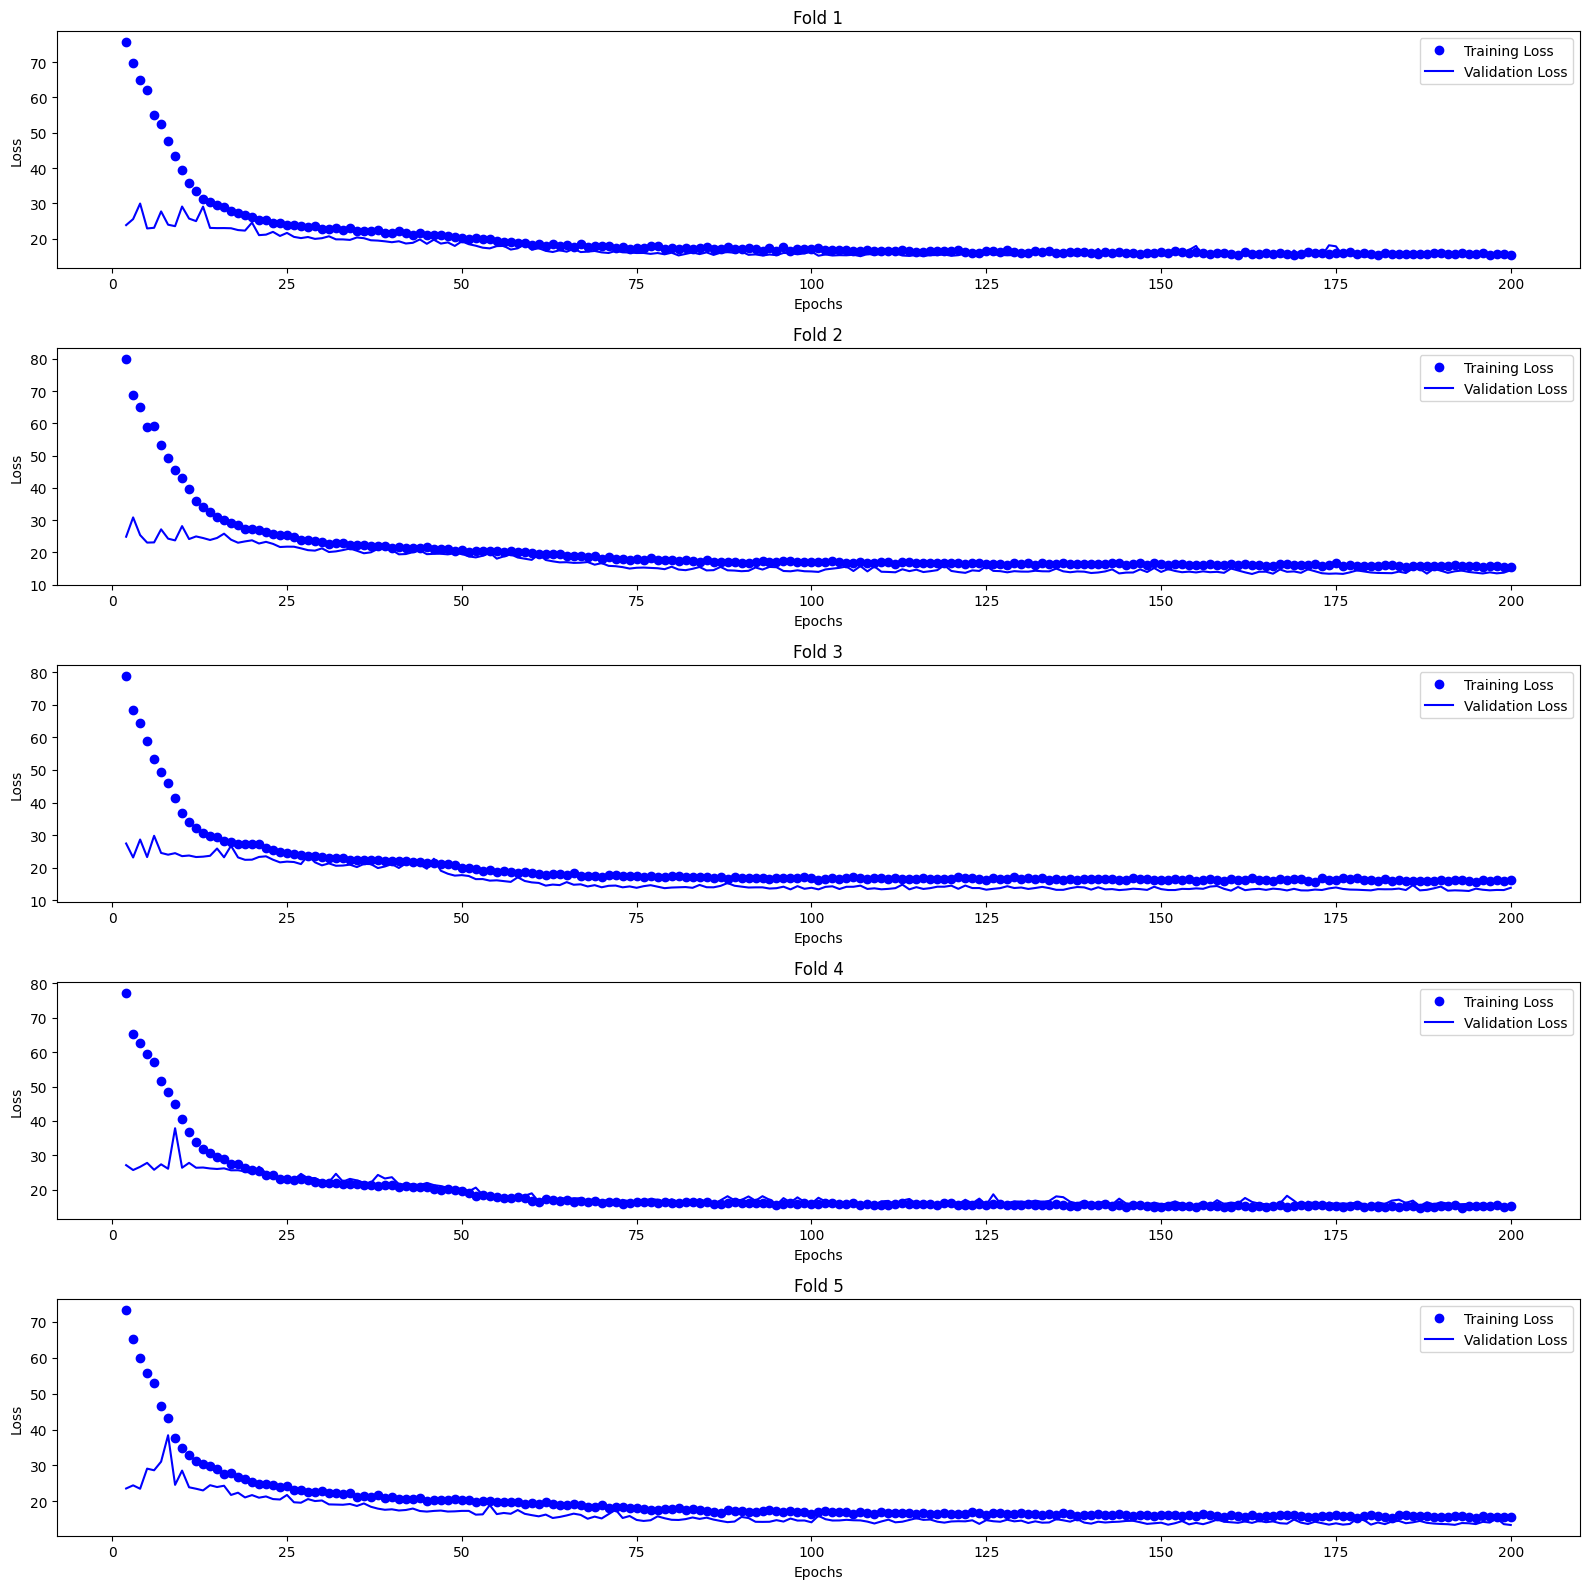

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(16,16))
fig.tight_layout()

start = 2
for i in range(5):
    history = histories[i]
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(start, len(loss) + 1)

    axs[i].plot(epochs, loss[start-1:], 'bo', label='Training Loss')
    axs[i].plot(epochs, val_loss[start-1:], 'b', label='Validation Loss')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()

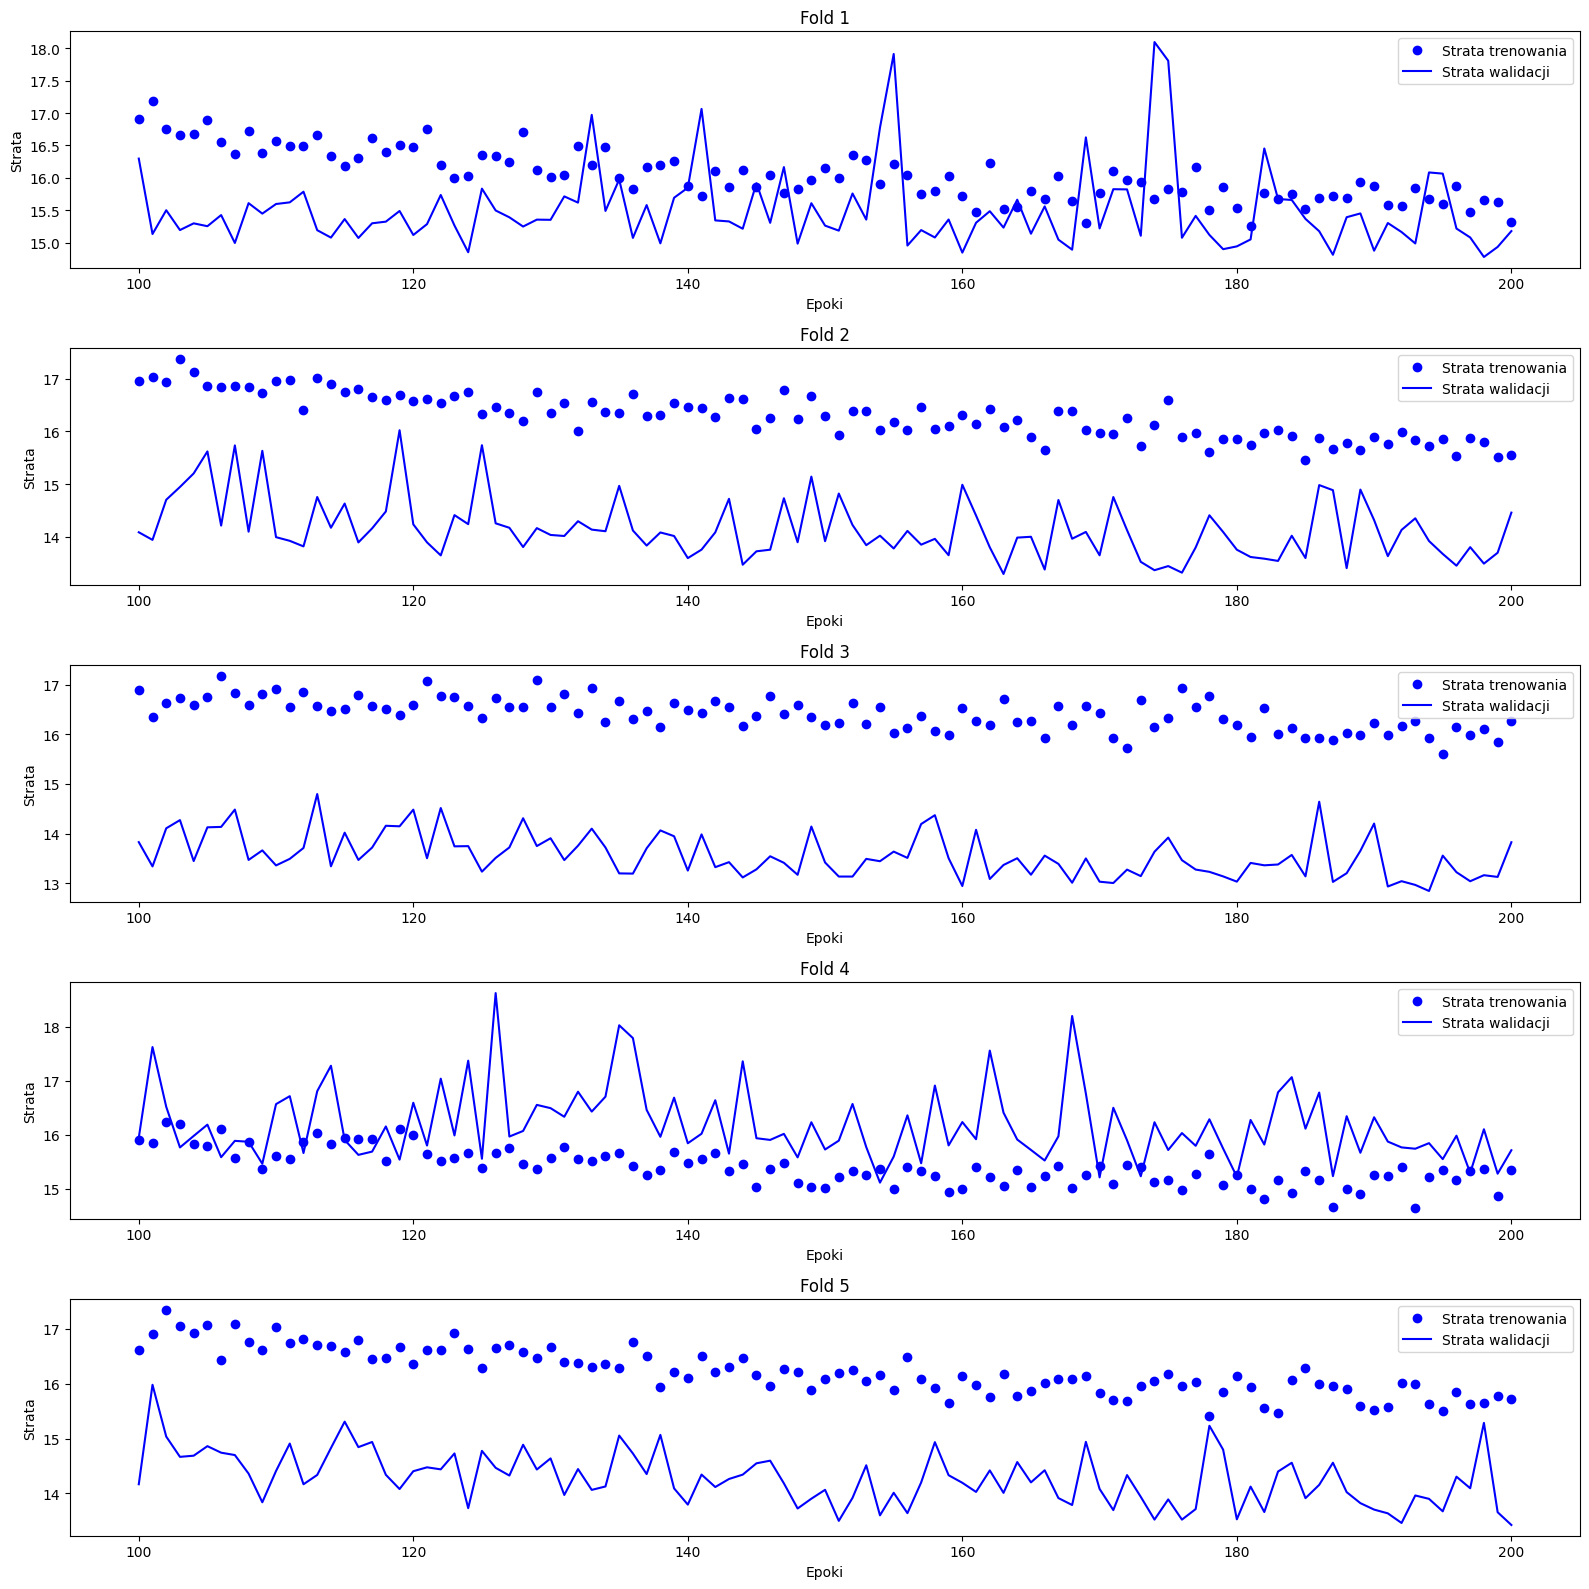

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(16,16))
fig.tight_layout()

start = 100
for i in range(5):
    history = histories[i]
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(start, len(loss) + 1)

    axs[i].plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
    axs[i].plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].set_xlabel('Epoki')
    axs[i].set_ylabel('Strata')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [25]:
predictions = best_model.predict(features[best_model_test])

42/42 [==============================] - 0s 915us/step


In [26]:
p_df = pd.DataFrame(columns=['Prediction', 'Actual', 'Difference'])

for i, prediction in enumerate(predictions):
    pred = prediction[0]
    act = targets[best_model_test][i]
    diff = pred - act

    p_df.loc[i] = {
        'Prediction': pred,
        'Actual': act,
        'Difference': abs(diff)
    }

In [27]:
p_df

,Prediction,Actual,Difference
0,54.026329,53.634200,0.392129
1,57.751930,57.943600,0.191670
2,58.858479,58.684400,0.174079
3,60.314331,59.851500,0.462831
4,60.827362,60.363600,0.463762
...,...,...,...
1313,61.335606,65.986642,4.651036
1314,63.470234,67.064549,3.594315
1315,65.368576,68.026773,2.658197
1316,72.001801,71.886202,0.115598


In [28]:
p_df.describe()

,Prediction,Actual,Difference
count,1318.000000,1318.000000,1318.000000
mean,68.749290,68.363747,2.523646
std,8.884368,9.401514,2.657180
min,45.136379,29.935300,0.003562
25%,63.203157,62.703175,0.782694
50%,70.084694,70.283226,1.754044
75%,75.355820,75.330200,3.378512
max,83.048096,85.258500,29.425921


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actual_values = p_df['Actual']
predicted_values = p_df['Prediction']

In [30]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_values, predicted_values)

# MSE mierzy średnią kwadratową różnicę między przewidzianymi a rzeczywistymi wartościami.
# MSE karze błędy większe bardziej niż błędy mniejsze. Jest czułe na wartości odstające.

# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(actual_values, predicted_values)

# MAE mierzy średnią bezwzględną różnicę między przewidzianymi a rzeczywistymi wartościami.
# MAE jest mniej wyczulone na wartości odstające w porównaniu z MSE.


# Calculate R-squared (R2) score
r2 = r2_score(actual_values, predicted_values)

# R2 mierzy proporcję wariancji zmiennej zależnej, która jest przewidywalna na podstawie zmiennych niezależnych.
# przyjmuje wartości od 0 do 1, gdzie 1 oznacza idealne dopasowanie.


In [31]:
# Display the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2) Score: {r2}')

# MSE i MAE są dobrym narzedziem do oceny wyników regresji, przy czym MSE jest bardziej czułe na większe błędy
# R2 może dostarczyć ogólnej miary dopasowania modelu, podczas gdy MSE i MAE mogą ułatwić zrozumienie wielkości błędów.

Mean Squared Error (MSE): 13.424033631419043
Mean Absolute Error (MAE): 2.52364559850028
R-squared (R2) Score: 0.8480092780732094


# Próba 1 - Modyfikacja warstw
- Dodanie dwóch warstw ukrytów
    - 16 i 8 węzłów
    - przed warstwą wyjściową

In [47]:
kfold = KFold(n_splits=5, shuffle=True)

features = np.asarray(features)
targets = np.asanyarray(targets)

histories = []
predictions_list = []
actual_values_list = []

best_model = None
best_model_test_loss = float('inf')
best_model_test = None

fold_no = 1
for train, test in kfold.split(features, targets):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    histories.insert(fold_no-1, model.fit(features[train], targets[train], epochs=200, batch_size=16, validation_data=(features[test], targets[test])))
    fold_no = fold_no + 1
    test_loss = model.evaluate(features[test], targets[test])
    print(f'Test Loss: {test_loss}')

    if test_loss < best_model_test_loss:
        best_model = model
        best_model_test_loss = test_loss
        best_model_test = test

Epoch 1/200
330/330 [==============================] - 2s 4ms/step - loss: 763.9740 - val_loss: 33.5519
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 75.6769 - val_loss: 25.9777
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 64.9552 - val_loss: 23.2002
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 57.2063 - val_loss: 37.7285
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 47.8264 - val_loss: 23.6517
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 41.2797 - val_loss: 24.6588
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 36.7056 - val_loss: 34.3258
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 34.2310 - val_loss: 32.5339
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 31.4440 - val_loss: 25.7906
Epoch 10/200
330/330 [==============================] - 1s 3ms/step - lo

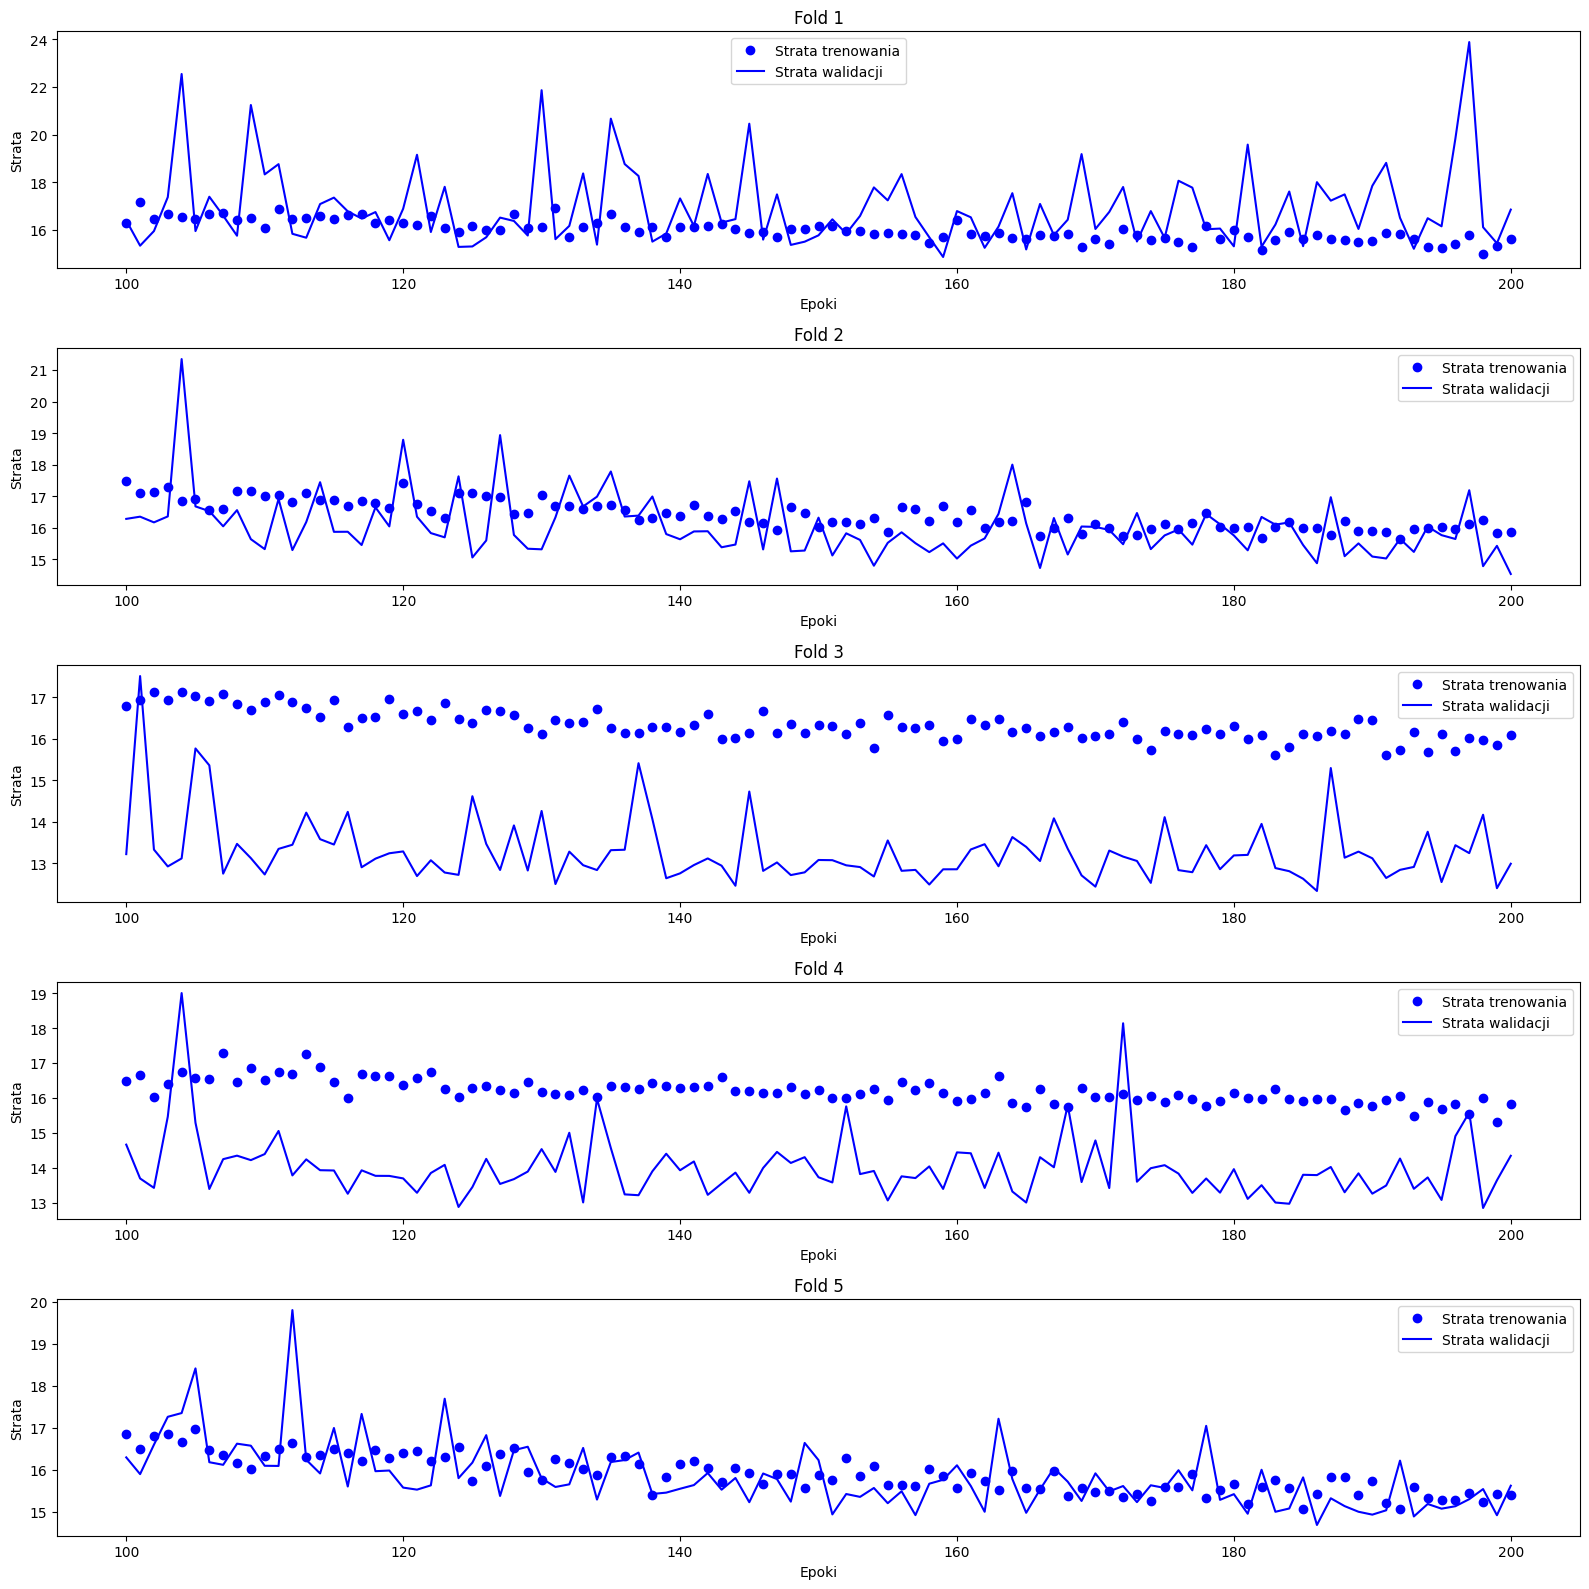

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(16,16))
fig.tight_layout()

start = 100
for i in range(5):
    history = histories[i]
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(start, len(loss) + 1)

    axs[i].plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
    axs[i].plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].set_xlabel('Epoki')
    axs[i].set_ylabel('Strata')
    axs[i].legend()

plt.tight_layout()
plt.show()

Brak zauważalnej poprawy dokładności modelu.

## Próba 2 - Batch Normalization
- BatchNormalization dodane do każdej warstwy, przed funkcją aktywacji

In [59]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation

features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')

Epoch 1/200
330/330 [==============================] - 3s 6ms/step - loss: 4287.3286 - val_loss: 3481.3813
Epoch 2/200
330/330 [==============================] - 2s 5ms/step - loss: 2568.1765 - val_loss: 1660.4807
Epoch 3/200
330/330 [==============================] - 2s 5ms/step - loss: 831.8148 - val_loss: 296.0422
Epoch 4/200
330/330 [==============================] - 2s 5ms/step - loss: 122.0311 - val_loss: 32.0858
Epoch 5/200
330/330 [==============================] - 2s 5ms/step - loss: 38.3938 - val_loss: 25.8202
Epoch 6/200
330/330 [==============================] - 2s 5ms/step - loss: 34.6203 - val_loss: 25.1904
Epoch 7/200
330/330 [==============================] - 1s 5ms/step - loss: 32.0125 - val_loss: 22.2906
Epoch 8/200
330/330 [==============================] - 2s 5ms/step - loss: 31.0920 - val_loss: 27.5888
Epoch 9/200
330/330 [==============================] - 2s 5ms/step - loss: 30.1067 - val_loss: 26.1525
Epoch 10/200
330/330 [==============================] - 1s 4ms

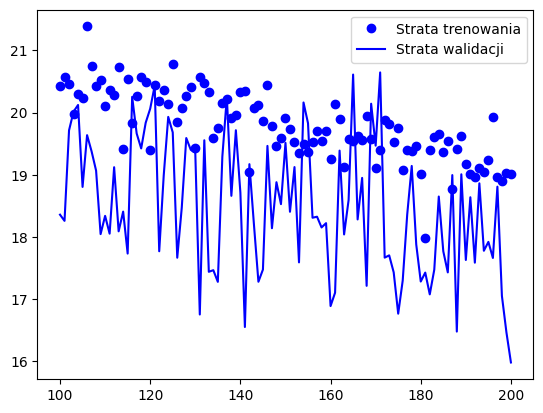

In [64]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Zmiany nie wpłynęły znacznie na dokładność modelu.

## Próba 3 - zwiększenie liczby węzłów sieci
- podwojono liczbę wezłów w ukrytych warstwach sieci

In [65]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation

features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')

Epoch 1/200
330/330 [==============================] - 2s 4ms/step - loss: 617.4473 - val_loss: 37.3865
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 51.4077 - val_loss: 22.4486
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 49.6603 - val_loss: 22.3087
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 47.1831 - val_loss: 25.2091
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 45.8811 - val_loss: 21.9896
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 44.7620 - val_loss: 22.2962
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 43.6987 - val_loss: 21.8985
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 42.7507 - val_loss: 26.7929
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 40.9686 - val_loss: 21.5213
Epoch 10/200
330/330 [==============================] - 1s 3ms/step - lo

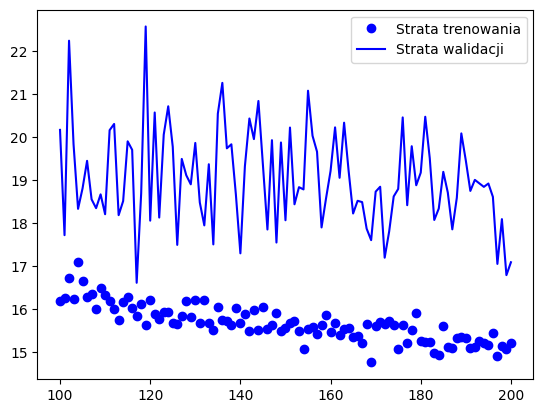

In [66]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Uczenie modelu po 200 epokach poskutkowało podobną dokładnością, ale model dalej poprawia wydajnoć nawet przy 200 epokach. Uczenie zostało kontynuowane aby sprawdzić jaki jest limit nowego modelu.

In [67]:
history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

Epoch 1/200
330/330 [==============================] - 1s 4ms/step - loss: 15.1594 - val_loss: 18.7687
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 14.9573 - val_loss: 18.7403
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 15.3453 - val_loss: 16.6904
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 14.9527 - val_loss: 18.6585
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 14.9741 - val_loss: 17.3301
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 15.4448 - val_loss: 18.7181
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 14.9271 - val_loss: 20.0610
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 14.9819 - val_loss: 18.8787
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 14.8972 - val_loss: 18.7790
Epoch 10/200
330/330 [==============================] - 1s 3ms/step - los

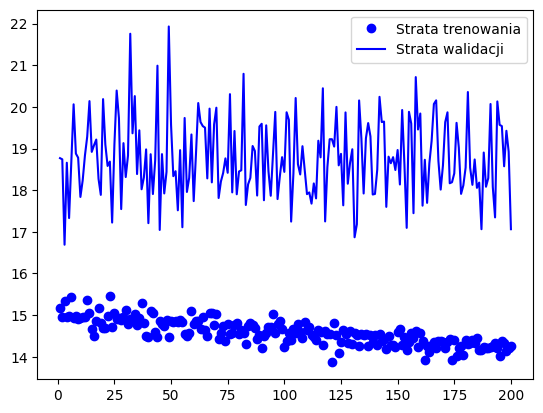

In [68]:
start = 1

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Kolejne 200 epok nie przynioszło porządanych efektów.

## Próba 3 - znaczne rozbudowanie architektury modelu

In [69]:
from keras.layers import Dense, Dropout, BatchNormalization

features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(features.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
330/330 [==============================] - 5s 11ms/step - loss: 4666.8286 - val_loss: 4521.9160
Epoch 2/200
330/330 [==============================] - 3s 10ms/step - loss: 3986.5942 - val_loss: 3534.0447
Epoch 3/200
330/330 [==============================] - 3s 10ms/step - loss: 2992.5654 - val_loss: 2431.4753
Epoch 4/200
330/330 [==============================] - 3s 10ms/step - loss: 1939.5033 - val_loss: 1431.8896
Epoch 5/200
330/330 [==============================] - 3s 10ms/step - loss: 1062.9801 - val_loss: 705.8079
Epoch 6/200
330/330 [==============================] - 3s 10ms/step - loss: 479.8269 - val_loss: 273.0389
Epoch 7/200
330/330 [==============================] - 3s 10ms/step - loss: 182.4360 - val_loss: 98.5551
Epoch 8/200
330/330 [==============================] - 3s 10ms/step - loss: 74.6501 - val_loss: 42.5122
Epoch 9/200
330/330 [==============================] - 3s 10ms/step - loss: 45.3561 - val_loss: 33.4907
Epoch 10/200
330/330 [====================

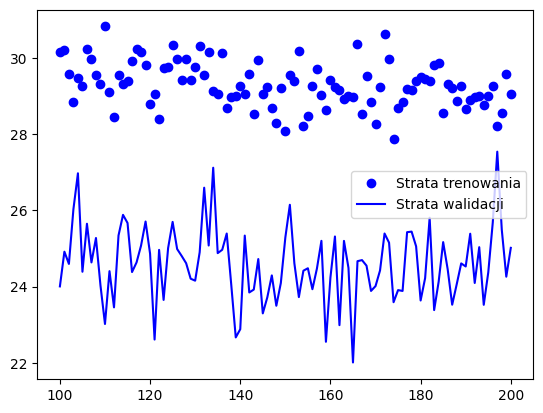

In [70]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

W skutek rozbudowania modelu i trenowania, które trwało 3 razy dłużej, osiągnięto gorsze wyniki.

## Próba 4 - zmniejszenie batch size
- z 16 na 4

In [71]:
features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(features, targets, epochs=200, batch_size=4, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
1319/1319 [==============================] - 5s 3ms/step - loss: 296.0436 - val_loss: 25.3123
Epoch 2/200
1319/1319 [==============================] - 4s 3ms/step - loss: 63.0425 - val_loss: 26.9368
Epoch 3/200
1319/1319 [==============================] - 4s 3ms/step - loss: 51.4881 - val_loss: 25.1475
Epoch 4/200
1319/1319 [==============================] - 4s 3ms/step - loss: 42.7129 - val_loss: 26.5266
Epoch 5/200
1319/1319 [==============================] - 4s 3ms/step - loss: 35.4434 - val_loss: 21.3180
Epoch 6/200
1319/1319 [==============================] - 4s 3ms/step - loss: 31.2416 - val_loss: 23.7290
Epoch 7/200
1319/1319 [==============================] - 4s 3ms/step - loss: 30.3916 - val_loss: 28.1431
Epoch 8/200
1319/1319 [==============================] - 4s 3ms/step - loss: 28.7118 - val_loss: 26.9548
Epoch 9/200
1319/1319 [==============================] - 4s 3ms/step - loss: 28.4597 - val_loss: 22.9548
Epoch 10/200
1319/1319 [==============================

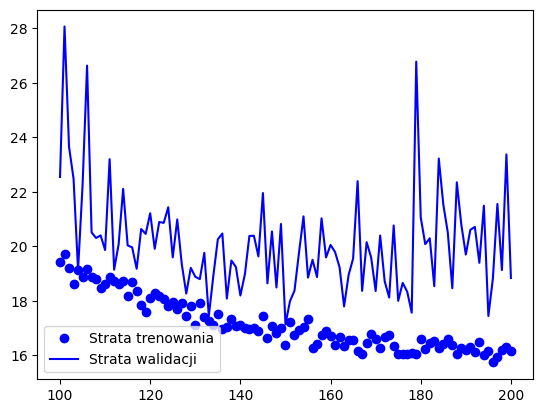

In [72]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Uzyskany wynik nie jest lepszy od pierwotnego.

## Próba 5 - znaczne uproszczenie architektury modelu
- 3 warstwy: 4 - 4 - 1

In [92]:
features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(4, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
330/330 [==============================] - 2s 4ms/step - loss: 4768.2437 - val_loss: 4281.1978
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 4091.2451 - val_loss: 3136.4609
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 2515.2085 - val_loss: 1266.9354
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 1481.4452 - val_loss: 606.4565
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 1275.6539 - val_loss: 550.5147
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 1176.9696 - val_loss: 492.3403
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 900.2833 - val_loss: 403.6159
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 711.7332 - val_loss: 430.5804
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 618.2714 - val_loss: 434.7690
Epoch 10/200
330/330 [========================

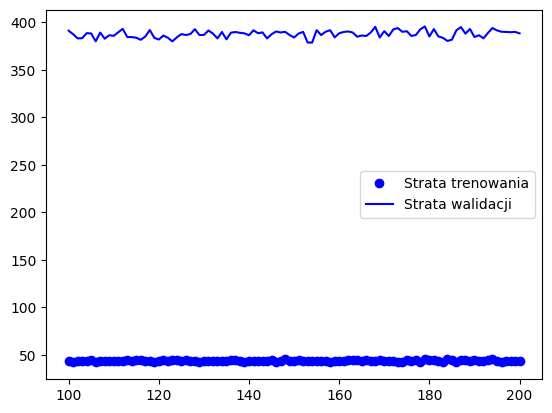

In [93]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Rozwiązanie znacznie pogorszyło wyniki sieci

## Próba 6 - lekkie uproszczenie architektury modelu
- 4 warstwy: 32 - 16 - 8 - 1

In [94]:
features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
330/330 [==============================] - 2s 4ms/step - loss: 2535.8696 - val_loss: 75.1143
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 239.9919 - val_loss: 63.5789
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 206.5966 - val_loss: 44.0554
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 182.3188 - val_loss: 44.3824
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 168.2159 - val_loss: 45.6180
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 142.2889 - val_loss: 29.9132
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 123.2731 - val_loss: 37.8695
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 104.6095 - val_loss: 34.5873
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 85.5311 - val_loss: 33.5604
Epoch 10/200
330/330 [==============================] - 1s 3ms/s

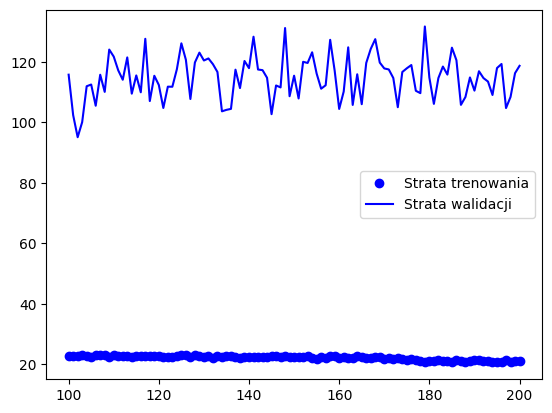

In [95]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Nawet lekkie uproszczenie modelu prowadzi do spadku dokładności sieci i szybszego przetrenowania.

## Próba 7 - warstwa dropout po każdej warstwie

In [97]:
features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
330/330 [==============================] - 1s 3ms/step - loss: 1349.0574 - val_loss: 98.6510
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 435.7167 - val_loss: 49.6803
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 416.7854 - val_loss: 62.5355
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 391.4395 - val_loss: 58.4161
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 388.8858 - val_loss: 84.3930
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 386.4948 - val_loss: 48.5498
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 374.5857 - val_loss: 59.1118
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 378.3845 - val_loss: 36.2765
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 360.0576 - val_loss: 52.0100
Epoch 10/200
330/330 [==============================] - 1s 3ms/

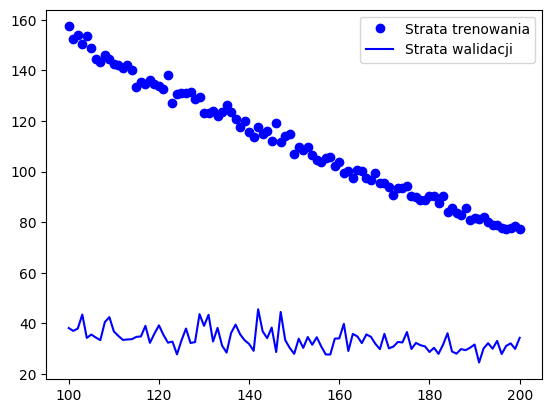

In [98]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Osiągnięte wyniki są gorsze od poprzednich. Dokładność walidacji nie poprawia się wraz z następnymi epokami.

## Próba 8 - Gradient Descent optimizer

In [104]:
features = np.asarray(features)
targets = np.asanyarray(targets)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(features.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='mean_squared_error')

history = model.fit(features, targets, epochs=200, batch_size=16, validation_split=0.2)

test_loss = model.evaluate(features, targets)
print(f'Test Loss: {test_loss}')


Epoch 1/200
330/330 [==============================] - 1s 3ms/step - loss: 467.1884 - val_loss: 27.9885
Epoch 2/200
330/330 [==============================] - 1s 3ms/step - loss: 41.4748 - val_loss: 156.5742
Epoch 3/200
330/330 [==============================] - 1s 3ms/step - loss: 36.4697 - val_loss: 25.9973
Epoch 4/200
330/330 [==============================] - 1s 3ms/step - loss: 31.6567 - val_loss: 26.6257
Epoch 5/200
330/330 [==============================] - 1s 3ms/step - loss: 32.7169 - val_loss: 28.5806
Epoch 6/200
330/330 [==============================] - 1s 3ms/step - loss: 29.2649 - val_loss: 27.2380
Epoch 7/200
330/330 [==============================] - 1s 3ms/step - loss: 31.1989 - val_loss: 26.9459
Epoch 8/200
330/330 [==============================] - 1s 3ms/step - loss: 29.3703 - val_loss: 83.2766
Epoch 9/200
330/330 [==============================] - 1s 3ms/step - loss: 29.0100 - val_loss: 34.5278
Epoch 10/200
330/330 [==============================] - 1s 3ms/step - l

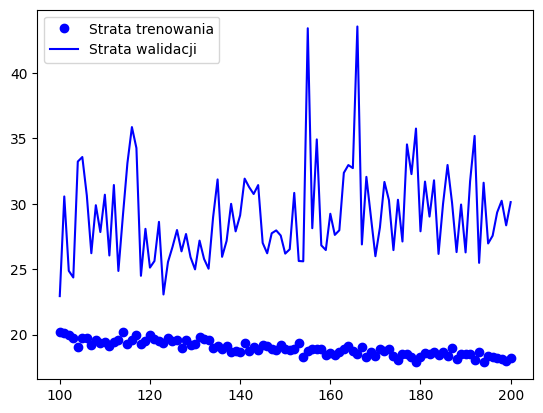

In [105]:
start = 100

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(start, len(loss) + 1)

plt.plot(epochs, loss[start-1:], 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss[start-1:], 'b', label='Strata walidacji')
plt.legend()

plt.show()

Uzyskane wynik są gorsze od pierwotnych.

## Wnioski:

Próby poprawnienia efektynwości modelu nie przyniosły skutku. Wyniki były porównywalne lub gorsze od pierwotnego:
- Podobne wyniki uzyskano gdy:
    - dodano dwie nowe warstwy ukryte
    - dodano batch normalization
    - zwiększono dwukrotnie liczbę węzłów w sieci
    - zmniejszono batch size z 16 do 4
- Gorsze wyniki uzyskano gdy:
    - podwojono liczbę węzłów, dodano nowe warstwy oraz batch normalization
    - znacznie zmniejszono liczbę warstw i węzłów w sieci (4 - 4 - 1)
    - lekko uproszczono architekturę modelu (32 - 16 - 8 - 1)
    - dodano warstwę dropout po każdej warstwie
    - użyto optimizera SGD (Gradient Descent)